In [59]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
plant_data = pd.read_csv("data/plant_moniter_health_data.csv")
plant_data = plant_data.drop(["Plant_ID", "Health_Score"],axis=1)
plant_data = plant_data.dropna()
plant_data.shape

(1000, 7)

### Classification Decision Tree

We used recursion to build a decision tree. The Algorithm chooses which vairable to use and what point as the split. For each decision it then calls itself with the data before the split and the data after the split. At each step it needs to evaluate whether its reached the stopping point based on:
* If it has reached the tree depth, d
* if the size of the dataset has reached a specific minimum size, min_n, aka node size
* all observations belong to the same class

Each found region in the input space will associate with a class of the response variable.

This algorithm is a greedy approach as at each decision call it will choose the variable best for splitting the input data. So therefore may not find the optimal tree. For each decision it:
* iterates: for each variable, find a splitting point that maximizes the difference between the mean y of the splits (as in where classes are most separated). (ESL Eq 9.17) Alternatively we could use the gini index or entropy to find the split.
* (regression - did not do this) choose the variable with the smallest sum of squares (ESL Eq 9.13) This can be calculated by finding the mean response y in each region and finding $y_reg - y_avg$. This is derived from (ESL Eq 9.14). The intention here is to have a region such that most of the observations in that region belong in the same class.
* (classification) Choose the variable that maximizes the split.




In [65]:

class DecisionTree():
    def __init__(self, max_depth: int = 5, current_depth: int = 0, minimum_node_size: int = 5, label: int = None):
        
        self.max_depth = max_depth
        self.current_depth = current_depth
        self.minimum_node_size = minimum_node_size
        
        if self.max_depth == 0:
            raise Exception("Max Depth = 0 is an invalid input")
        
        self.missclassification = None
        self.label = label
        self.left_tree = None
        self.right_tree = None
        self.split_variable = None
        self.split_value = None
        
    def _find_best_split(self, X, Y):
        best_missclassification = float("-inf")
        best_split_variable = None
        best_split_value = None
        labels = None
        
        for variable in range(X.shape[1]):
            var_values = X.iloc[:, variable].unique()
            var_values.sort()
            for val in var_values[self.minimum_node_size: -self.minimum_node_size]:
                smaller_than_val = Y[X.iloc[:, variable] < val]
                greater_than_val = Y[X.iloc[:, variable] >= val]
                if smaller_than_val.shape[0] == 0 or greater_than_val.shape[0] == 0:
                    continue
                # difference in the means of the 2 classes. This diffierence should be maximized
                missclassification = np.abs(np.mean(smaller_than_val) - np.mean(greater_than_val))
                if missclassification > best_missclassification:
                    best_missclassification = missclassification
                    best_split_variable = variable
                    best_split_value = val
                    if np.mean(smaller_than_val) - np.mean(greater_than_val) < 0:
                        labels = [0, 1]
                    else:
                        labels = [1, 0]
   
        return best_split_variable, best_split_value, labels
        
    def fit(self, X, Y):
        if self.current_depth >= self.max_depth:
            return None
        if X.shape[0] <= self.minimum_node_size:
            return None 

        if self.label is None:
            self.label = 0 if np.mean(Y) < 0.5 else 1
        self.missclassification = np.abs(np.mean(Y) - self.label)
        if self.missclassification == 0:
            return self
        
        self.split_variable, self.split_value, labels = self._find_best_split(X, Y)
        
        if self.split_variable is None:
            return self
        
        smaller_than_val = X[X.iloc[:, self.split_variable] < self.split_value]
        greater_than_val = X[X.iloc[:, self.split_variable] >= self.split_value]
        smaller_than_val_Y = Y[X.iloc[:, self.split_variable] < self.split_value]
        greater_than_val_Y = Y[X.iloc[:, self.split_variable] >= self.split_value]
        
        left_tree = DecisionTree(
            max_depth=self.max_depth, 
            current_depth=self.current_depth + 1, 
            minimum_node_size=self.minimum_node_size,
            label =labels[0],
            ).fit(smaller_than_val, smaller_than_val_Y)
        right_tree = DecisionTree(
            max_depth=self.max_depth, 
            current_depth=self.current_depth + 1, 
            minimum_node_size=self.minimum_node_size,
            label =labels[1],
            ).fit(greater_than_val, greater_than_val_Y)
        
        if left_tree and right_tree:
            self.left_tree = left_tree.fit(smaller_than_val, smaller_than_val_Y)
            self.right_tree = right_tree.fit(greater_than_val, greater_than_val_Y)
        
        return self
    
    def _prediction_find(self, X):
        if self.left_tree is None:
            return self.label
        if X.iloc[self.split_variable] < self.split_value:
            return self.left_tree._prediction_find(X)
        else:
            return self.right_tree._prediction_find(X)
        
    def predict(self, newdata):
        predictions = []
        for i in range(newdata.shape[0]):
            predictions.append(self._prediction_find(newdata.iloc[i, :-1]))
        predictions = np.array(predictions)
        return predictions
    
        
        

In [66]:
train_num = int(plant_data.shape[0]*0.75)

train_i = np.random.choice(plant_data.shape[0], train_num, replace=False)
train_data = plant_data.iloc[train_i, :]
test_data = plant_data.drop(train_i, axis=0)

decision_tree = DecisionTree(max_depth=5, minimum_node_size=5)
decision_tree.fit(train_data.iloc[:, :-1], train_data.iloc[:, -1])


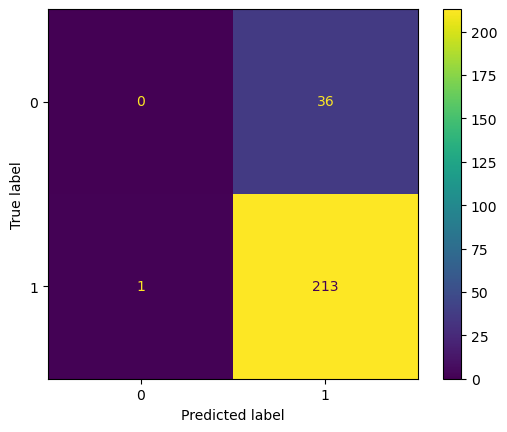

In [67]:
predictions = decision_tree.predict(test_data.iloc[:, :-1])

cm = confusion_matrix(test_data.iloc[:, -1], predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()

In [68]:
compare = pd.DataFrame({"Actual": test_data.iloc[:, -1], "Predicted": predictions})
compare["Correct"] = compare["Actual"] == compare["Predicted"]
np.mean(compare["Correct"])

0.852